In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/aqua_test_indices.pkl', allow_pickle=True)
test_indices

array([33370, 22950,   330, ..., 30403, 21243,  2732])

In [3]:
aqua_modis_estimate = pd.read_pickle(f"data/OCEAN_aqua_transformed_modo_targets.pkl")
aqua_modis_estimate.describe()

,mTau470,mTau550,mTau660,mTau870
count,3.358900e+04,3.358900e+04,33589.000000,33589.000000
mean,-6.090963e-07,1.984083e-07,-0.000001,0.000001
std,1.000026e+00,1.000017e+00,1.000021,1.000012
min,-7.651633e+00,-6.943613e+00,-6.041388,-4.459335
25%,-7.064400e-01,-7.220420e-01,-0.710413,-0.710553
50%,-1.074787e-02,-6.128825e-03,-0.004049,0.002267
75%,7.007103e-01,7.100617e-01,0.702820,0.688572
max,3.598073e+00,3.470232e+00,3.419137,3.452862


In [4]:
aqua_y_test = pd.read_pickle('model_outputs/aqua_y_test.pkl')
aqua_y_test.describe()

,aTau470,aTau550,aTau660,aTau870
count,3359.000000,3359.000000,3359.000000,3359.000000
mean,0.022496,0.020852,0.017931,0.012182
std,0.991382,0.991251,0.991583,0.999631
min,-2.966015,-3.202452,-3.181109,-6.955210
25%,-0.702650,-0.669076,-0.667966,-0.658295
50%,0.023550,0.018693,0.004004,-0.002238
75%,0.750721,0.732633,0.709161,0.684957
max,3.200281,3.123235,2.999283,2.853992


In [5]:
aqua_mlp_out = pd.read_pickle('model_outputs/aqua_mlp_out.pkl')
aqua_mlp_out.describe()

,aTau470,aTau550,aTau660,aTau870
count,3359.000000,3359.000000,3359.000000,3359.000000
mean,0.020521,0.017726,0.013935,0.003055
std,0.928580,0.928467,0.926457,0.912847
min,-2.653799,-2.652770,-2.591491,-2.488272
25%,-0.660247,-0.666379,-0.663992,-0.649417
50%,-0.045760,-0.050014,-0.067831,-0.076973
75%,0.701616,0.693212,0.657051,0.615665
max,3.108203,3.010520,3.032098,3.041582


In [6]:
aqua_edl_out_np = np.load('model_outputs/aqua_edl_out_edl_param=0.1.npy')
aqua_mu, aqua_v, aqua_alpha, aqua_beta = tf.split(aqua_edl_out_np, [aqua_mlp_out.shape[1] for i in range(4)], axis=-1)
aqua_var = np.sqrt(aqua_beta / (aqua_v * (aqua_alpha - 1)))
aqua_edl_out = pd.DataFrame(aqua_mu.numpy(), columns=aqua_mlp_out.columns)
aqua_edl_out_np

2022-03-07 01:39:34.899830: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


array([[-3.42403501e-01, -3.28016937e-01, -2.98832357e-01, ...,
         1.21254758e-04,  1.22176702e-04,  1.10920984e-04],
       [-1.58914733e+00, -1.59821355e+00, -1.59593511e+00, ...,
         7.39012467e-05,  9.48981324e-05,  4.95918539e-05],
       [ 1.19136512e-01,  1.72539353e-02, -1.09425724e-01, ...,
         9.48053348e-05,  1.10500267e-04,  8.54235914e-05],
       ...,
       [-5.13103843e-01, -4.71181750e-01, -4.04908597e-01, ...,
         9.63175989e-05,  9.40604950e-05,  8.97211721e-05],
       [-1.78971589e-02,  8.42387676e-02,  2.11734921e-01, ...,
         1.05645478e-04,  8.84963374e-05,  1.04895880e-04],
       [-5.52042603e-01, -5.82701147e-01, -6.13782585e-01, ...,
         2.76962746e-05,  3.13596101e-05,  1.98721864e-05]], dtype=float32)

In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 3359 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


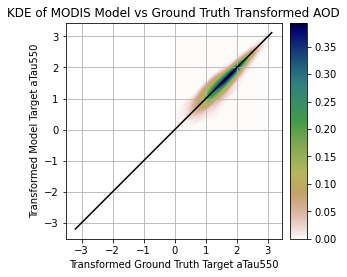

In [8]:
transformed_y_test = aqua_y_test.aTau550
transformed_modis_y_test_aod = aqua_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 3359 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


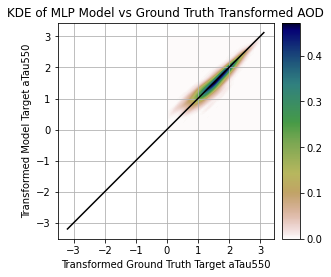

In [9]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_df = aqua_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

In [10]:
aqua_edl_out.aTau550

0      -0.328017
1      -1.598214
2       0.017254
3       1.102726
4      -1.651160
          ...   
3354    0.868637
3355    1.404610
3356   -0.471182
3357    0.084239
3358   -0.582701
Name: aTau550, Length: 3359, dtype: float32

Starting the 2D kernel density estimation with 3359 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


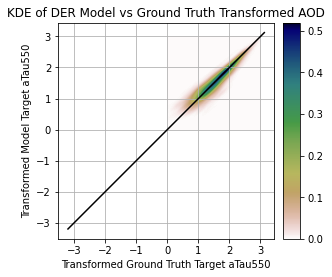

In [11]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_edl_df = aqua_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.9140305209674634 -0.010677416866546718 0.9108735859381557 0.0 0.007147367517702434
0.9108735859381557


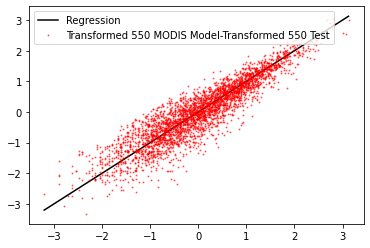

In [12]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.8702550142698912 -0.00042091745407823664 0.9291021368730373 0.0 0.00597862878312803
0.9291021368730373


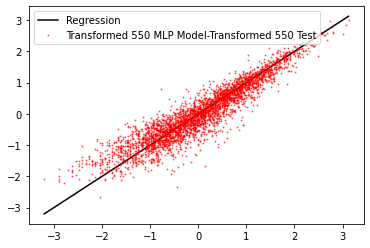

In [13]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.8665763872802202 0.002099316975287098 0.9272243619340267 0.0 0.00604095354559114
0.9272243619340267


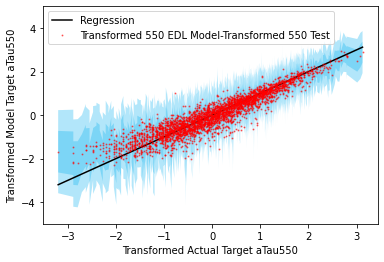

In [14]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.8665763872802202 0.002099316975287098 0.9272243619340267 0.0 0.00604095354559114
[-0.32801694 -1.5982136   0.01725394 ... -0.47118175  0.08423877
 -0.58270115]
0.9272243619340267


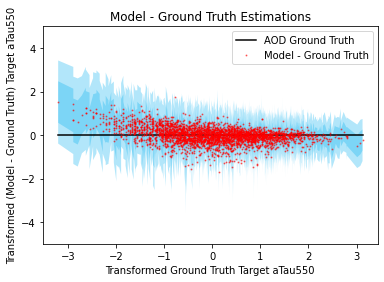

In [15]:
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

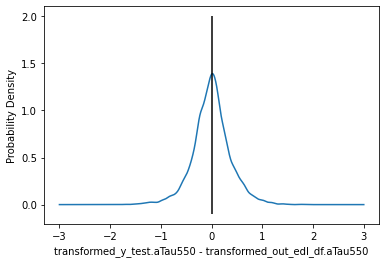

In [22]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')